In [1]:
import pandas as pd
import bayesian_pdes as bpdes
import sympy as sp
import numpy as np
import GPy, GPyOpt
import scipy, scipy.spatial
import matplotlib.pyplot as plt
import gpanim
import bayesian_design as bd
%matplotlib inline

warning in stationary: failed to import cython module: falling back to numpy


In [63]:
np.__config__.show()

lapack_opt_info:
    extra_link_args = ['-Wl,-framework', '-Wl,Accelerate']
    extra_compile_args = ['-msse3', '-DAPPLE_ACCELERATE_SGEMV_PATCH']
    define_macros = [('NO_ATLAS_INFO', 3)]
openblas_lapack_info:
  NOT AVAILABLE
atlas_3_10_blas_threads_info:
  NOT AVAILABLE
atlas_threads_info:
  NOT AVAILABLE
atlas_3_10_threads_info:
  NOT AVAILABLE
atlas_blas_info:
  NOT AVAILABLE
atlas_3_10_blas_info:
  NOT AVAILABLE
atlas_blas_threads_info:
  NOT AVAILABLE
openblas_info:
  NOT AVAILABLE
blas_mkl_info:
  NOT AVAILABLE
blas_opt_info:
    extra_link_args = ['-Wl,-framework', '-Wl,Accelerate']
    extra_compile_args = ['-msse3', '-DAPPLE_ACCELERATE_SGEMV_PATCH', '-I/System/Library/Frameworks/vecLib.framework/Headers']
    define_macros = [('NO_ATLAS_INFO', 3)]
atlas_info:
  NOT AVAILABLE
atlas_3_10_info:
  NOT AVAILABLE
lapack_mkl_info:
  NOT AVAILABLE
mkl_info:
  NOT AVAILABLE


In [2]:
x_1,x_2, y_1, y_2 = sp.symbols('x_1 x_2 y_1 y_2')
length_scale = 0.5
k = sp.exp(-((x_1-y_1)**2 + (x_2-y_2)**2) / (2*length_scale)**2)
def A(f): return f.diff(x_1,x_1) + f.diff(x_2, x_2)
def Abar(f): return f.diff(y_1,y_1) + f.diff(y_2, y_2)
def Identity(f): return f

ops = [A, Identity]
ops_bar = [Abar, Identity]

obs_per_bdy = 4
# need some observations scattered on the bdy
bdy_locs = [
    [[0., y] for y in np.random.uniform(0,1,obs_per_bdy)],
    [[1., y] for y in np.random.uniform(0,1,obs_per_bdy)],
    [[x, 0.] for x in np.random.uniform(0,1,obs_per_bdy)],
    [[x, 1.] for x in np.random.uniform(0,1,obs_per_bdy)],
]
bdy_locs = np.concatenate(bdy_locs)

bdy_values = np.zeros((bdy_locs.shape[0], 1))
bdy_obs = (bdy_locs, bdy_values)

In [40]:
def vectorize_along_axis(function):
    def __ret(points):
        return np.array([[function(points[i,:])] for i in xrange(points.shape[0])])
    return __ret

In [3]:
op_cache = bpdes.generate_op_cache(ops, ops_bar, k, [[x_1, x_2], [y_1, y_2]], mode='compile')

In [4]:
# random observation locations inside the space
interior_obs = 10
obs_locations = np.hstack([np.random.uniform(0,1,interior_obs)[:,None], np.random.uniform(0,1,interior_obs)[:,None]])

In [26]:
def rhs(pts):
    return (np.sin(2*np.pi*pts[:,0])*np.sin(2*np.pi*pts[:,1]))[:,None]
obs_values = rhs(obs_locations)

indexer = np.arange(len(obs_locations))
orig_locations = obs_locations.copy()
orig_values = obs_values.copy()
orig_posterior = bpdes.collocate(ops, ops_bar, k, [[x], [y]], [(orig_locations, orig_values), bdy_obs], op_cache)

**Deletion function** 

In the terminology of Meyer & Nachtsheim we are using a linear design (i.e. $L(D) = tr(D)$, where D is my variance-covariance matrix). Then following their terminology my deletion function ought to be:

$$
d_L(x_i) = \frac{\phi(x_i)}{1-v(x_i)} \\
\phi(x_i) = L(D f(x_i) f(x_i)^T D) \\
v(x_i) = f(x_i) D f(x_i)^T
$$

Now then the question becomes - who is this $f$ and what does he have to do with anything? It seems that $f$ is like a feature function? i.e. $f^T(x_i)$ is supposed to be the $i$-th row of the design matrix. So am I worrying about nothing? i.e. $\phi = trace(\Sigma)$, $v(x_i) = \Sigma_{ii}$? 

(0, 1)

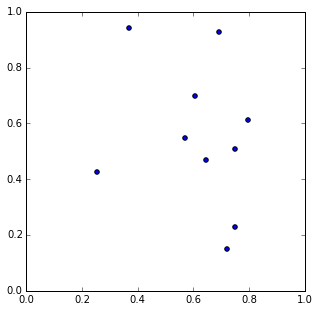

In [32]:
plt.figure(figsize=(5,5))
plt.scatter(orig_locations[:,0], orig_locations[:,1])
plt.xlim(0,1)
plt.ylim(0,1)

In [20]:
def loss_vect(pts):
    return np.array([[loss(pts[i,:])] for i in xrange(pts.shape[0])])

In [25]:
test_x, test_y = np.mgrid[0:1:10j, 0:1:10j]
test_space = np.c_[test_x.ravel(), test_y.ravel()]
adjust_domain = 0.4
emu_length_scale = 0.05
emu_design_points = 20

def design_space(d):
    bounds = get_optimizer_bounds(d)
    xs = np.random.uniform(bounds[0][0], bounds[0][1], emu_design_points)
    ys = np.random.uniform(bounds[1][0], bounds[1][1], emu_design_points)
    return np.c_[xs, ys]

# todo: significantly more efficient to use a moore-penrose inverse here but a bit complicated...
def get_cov(points):
    if points.shape == (2,):
        points = points.reshape((1,2))
    obs = rhs(points)
    posterior = bpdes.collocate(ops, ops_bar, k, [[x], [y]], [(points, obs), bdy_obs], op_cache)
    _,cov = posterior(test_space)
    return cov

def get_optimizer_bounds(point):
    return [(max(point[0]-adjust_domain, 0.), min(point[0]+adjust_domain, 1.)), 
            (max(point[1]-adjust_domain, 0.), min(point[1]+adjust_domain, 1.))]

def naive_emu_optimizer(function, cur_point, other_points):
    emu_bounds = get_optimizer_bounds(cur_point)
    emu = random_gp_emulator(emu_length_scale, 2, design_space, function)(emu_bounds, cur_point)
    return scipy.optimize.minimize(lambda x: emu(x)*1e10, cur_point, bounds=emu_bounds).x


def random_gp_emulator(length_scale, input_dim, design_fn, loss):
    import GPy

    def gpy_emulator(bounds, pt):
        inputs = design_fn(pt)
        values = np.array([[loss(inputs[i, :])] for i in xrange(inputs.shape[0])])

        model = GPy.models.GPRegression(inputs, values, GPy.kern.RBF(input_dim=input_dim, lengthscale=length_scale))
        return lambda x: model.predict(np.atleast_2d(x))[0]
    return gpy_emulator

optimizer = bd.optimizers.gpyopt_optimizer(get_optimizer_bounds, True)
loss = bd.a_optimality(get_cov)

In [42]:
n_points = 10
initial_design = np.empty((n_points,2))
for i in xrange(n_points):
    cur_points = initial_design[:i,:]
    def partial_loss(p):
        aug_points = np.concatenate((cur_points, p.reshape((1,2))))
        return loss(aug_points)
    
    opt = GPyOpt.methods.BayesianOptimization(vectorize_along_axis(partial_loss), [(0,1), (0,1)])
    opt.run_optimization()
    initial_design[i,:] = opt.x_opt
    print i, initial_design[i,:]

*Optimization completed:
   -Maximum number of iterations reached.
0 [ 0.44786276  0.45371159]
*Optimization completed:
   -Maximum number of iterations reached.
1 [ 0.46813755  0.48008308]
*Optimization completed:
   -Maximum number of iterations reached.
2 [ 0.61356383  0.36165042]
*Optimization completed:
   -Maximum number of iterations reached.
3 [ 0.43861627  0.82085318]
*Optimization completed:
   -Maximum number of iterations reached.
4 [ 0.37061457  0.44378903]
*Optimization completed:
   -Maximum number of iterations reached.
5 [ 0.23970084  0.54027052]
*Optimization completed:
   -Maximum number of iterations reached.
6 [ 0.95594868  0.89797682]
*Optimization completed:
   -Maximum number of iterations reached.
7 [ 0.07683263  0.06405506]
*Optimization completed:
   -Maximum number of iterations reached.
8 [ 0.9481657   0.02014007]
*Optimization completed:
   -Maximum number of iterations reached.
9 [ 0.60156983  0.84979232]


2.83603268111e-09


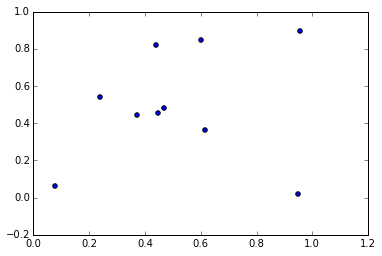

In [49]:
plt.scatter(initial_design[:,0], initial_design[:,1])
print loss(initial_design)
initial_values = rhs(initial_design)
orig_posterior = bpdes.collocate(ops, ops_bar, k, [[x], [y]], [(initial_design, initial_values), bdy_obs], op_cache)

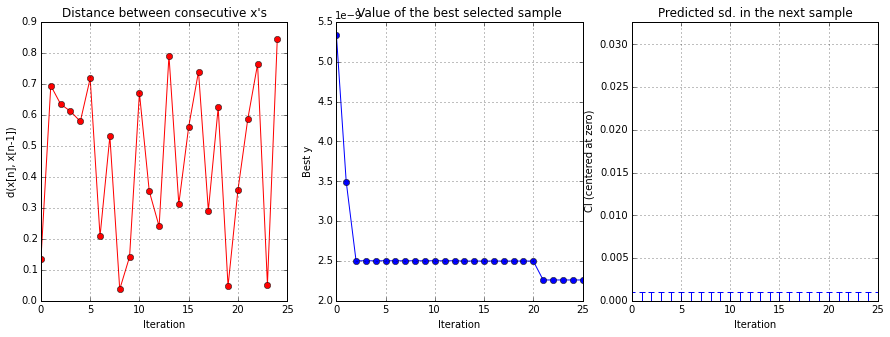

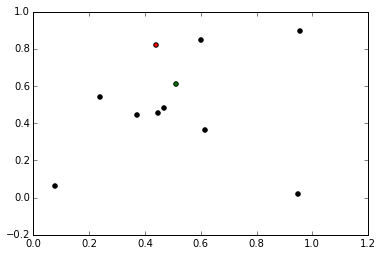

0 Moved 3 from [ 0.43861627  0.82085318] to [ 0.51050057  0.612665  ] (new loss 2.26e-09 < 2.84e-09)


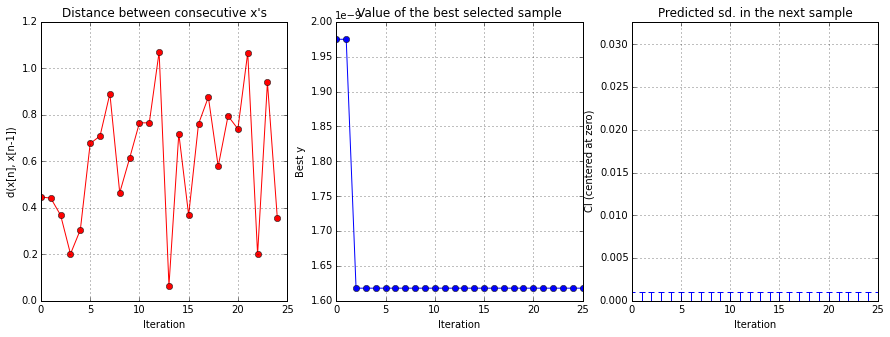

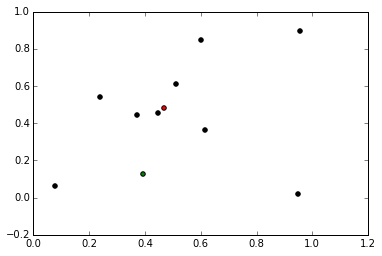

1 Moved 1 from [ 0.46813755  0.48008308] to [ 0.39317717  0.12487741] (new loss 1.62e-09 < 2.26e-09)


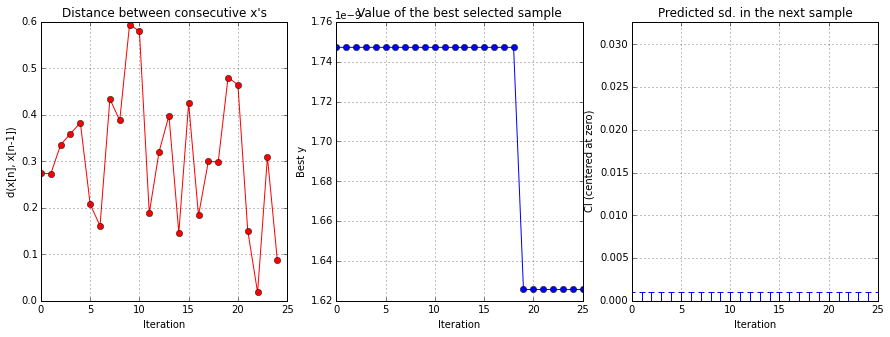

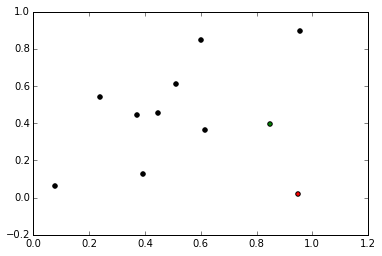

2 Rejected move of 8 from [ 0.9481657   0.02014007] to [ 0.84674061  0.39331027], (new loss 1.63e-09 > 1.62e-09)


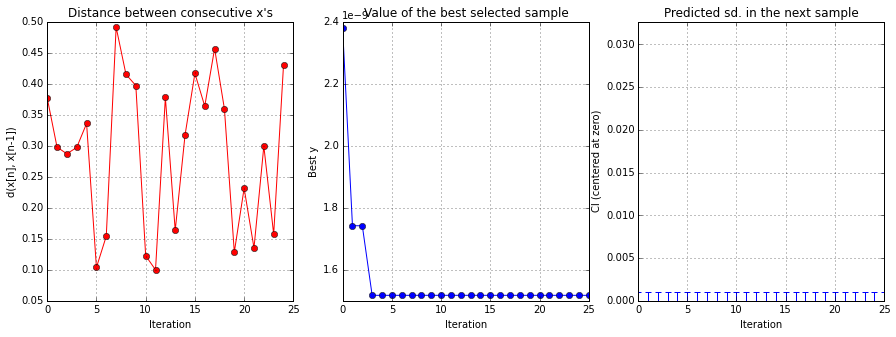

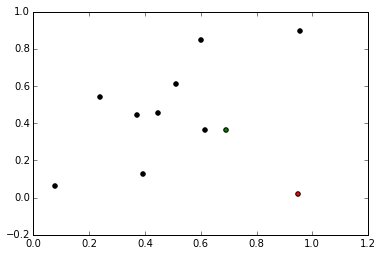

3 Moved 8 from [ 0.9481657   0.02014007] to [ 0.69049151  0.36337448] (new loss 1.52e-09 < 1.62e-09)


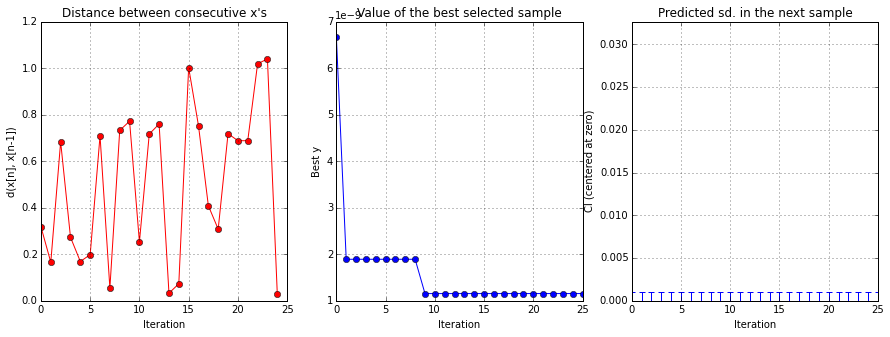

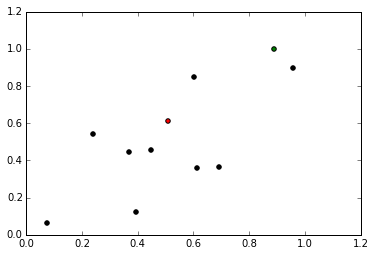

4 Moved 3 from [ 0.51050057  0.612665  ] to [ 0.88825662  0.99719716] (new loss 1.16e-09 < 1.52e-09)


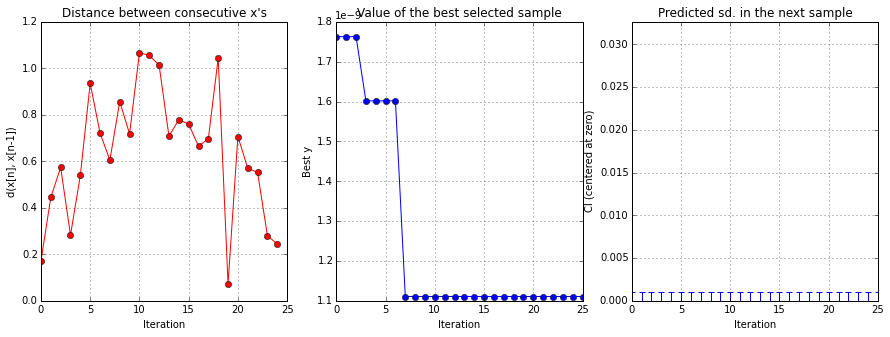

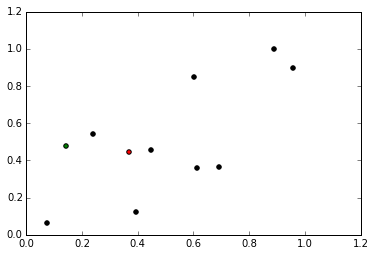

5 Moved 4 from [ 0.37061457  0.44378903] to [ 0.14472426  0.47940107] (new loss 1.11e-09 < 1.16e-09)


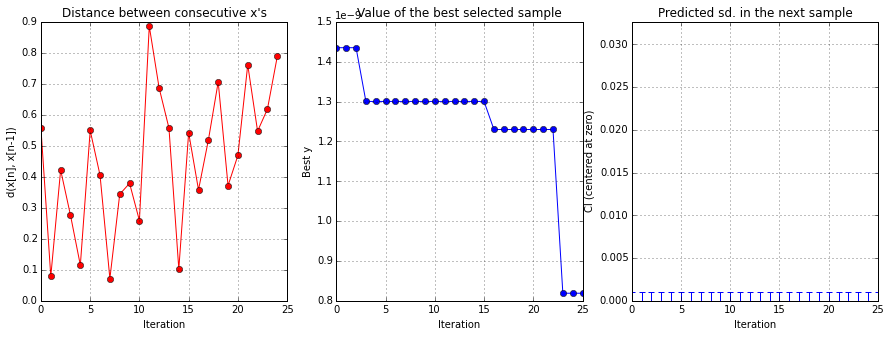

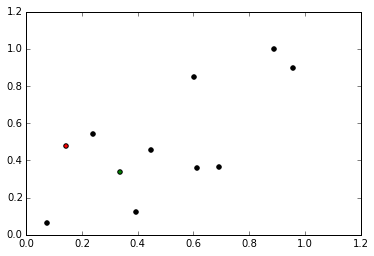

6 Moved 4 from [ 0.14472426  0.47940107] to [ 0.33599168  0.33886556] (new loss 8.19e-10 < 1.11e-09)


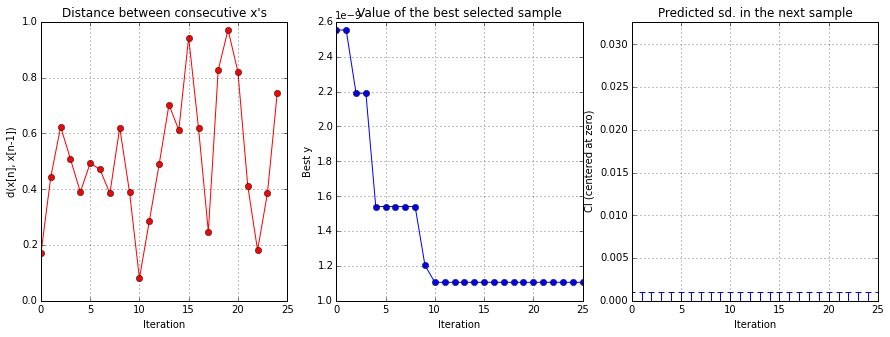

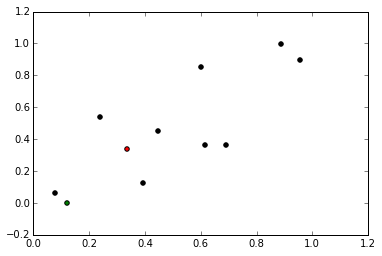

7 Rejected move of 4 from [ 0.33599168  0.33886556] to [ 0.12017576  0.00118272], (new loss 1.11e-09 > 8.19e-10)


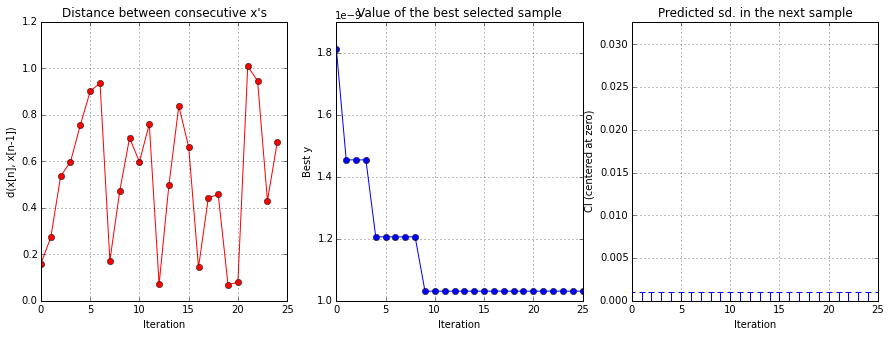

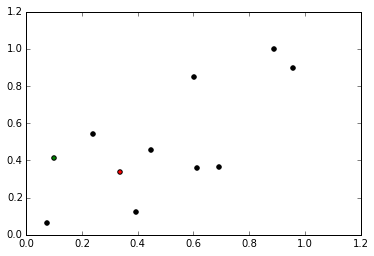

8 Rejected move of 4 from [ 0.33599168  0.33886556] to [ 0.10171242  0.41251095], (new loss 1.03e-09 > 8.19e-10)


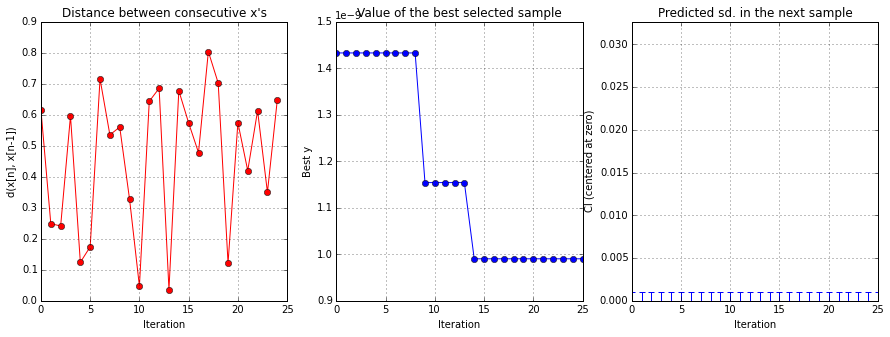

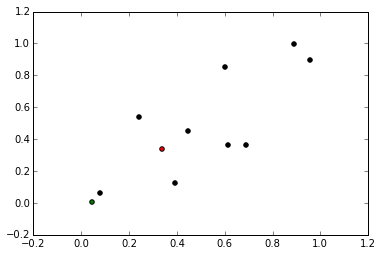

9 Rejected move of 4 from [ 0.33599168  0.33886556] to [ 0.046792    0.00773762], (new loss 9.90e-10 > 8.19e-10)


In [51]:
optimal_design = bd.ace( 
    initial_design, 
    1, 
    10, 
    loss, 
    optimizer, 
    True
)

In [57]:
initial_posterior = bpdes.collocate(ops, ops_bar, k, None, [(initial_design, rhs(initial_design)), bdy_obs], op_cache)
optimal_posterior = bpdes.collocate(ops, ops_bar, k, None, [(optimal_design, rhs(optimal_design)), bdy_obs], op_cache)

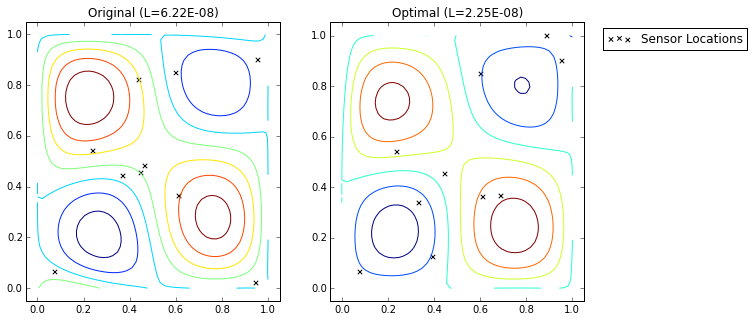

In [58]:
from IPython.display import display
plt.figure(figsize=(10,5))
plot_x, plot_y = np.mgrid[0:1:50j, 0:1:50j]

plt.subplot(121)
mu, cov = initial_posterior(np.c_[plot_x.ravel(), plot_y.ravel()])
#plt.plot(test_points, np.random.multivariate_normal(mu.ravel(),cov,500).T, c='gray', alpha=0.1)
plt.contour(plot_x, plot_y, mu.reshape(plot_x.shape))
plt.scatter(initial_design[:,0], initial_design[:,1], c='black', marker='x')
plt.title('Original (L={:.2E})'.format(np.sum(np.diag(cov)**2)))

plt.subplot(122)
mu, cov = optimal_posterior(np.c_[plot_x.ravel(), plot_y.ravel()])
#plt.plot(test_points, np.random.multivariate_normal(mu.ravel(),cov,500).T, c='gray', alpha=0.1)
plt.contour(plot_x, plot_y, mu.reshape(plot_x.shape))
plt.scatter(optimal_design[:,0], optimal_design[:,1], c='black', marker='x', label='Sensor Locations')
plt.title('Optimal (L={:.2E})'.format(np.sum(np.diag(cov)**2)))
plt.legend(loc=2, bbox_to_anchor=(1.05,1))